<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Взглянем-на-результаты:" data-toc-modified-id="Взглянем-на-результаты:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Взглянем на результаты:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></div>

#  Прогнозирование заказов такси

Сервис заказа такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель исследования:** Написать модель для предсказания количества заказов такси на следующий час, основываясь на исторических данных.

**План исследования:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
# base stuff
import pandas as pd
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit

# boosting
from lightgbm import LGBMRegressor
from catboost import Pool, CatBoostRegressor

In [2]:
taxi_data = pd.read_csv('/datasets/taxi.csv')
display(taxi_data)
taxi_data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Теперь когда мы знаем как выглядят даннные, можем открыть их заного, указав, дату как индекс:

In [3]:
taxi_data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
display(taxi_data)
taxi_data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Похоже, что данные собранны с 1 марта 2018 по 31 августа 2018 с интервалом в 10 минут. Проверим расположены ли данные в хронологическом порядке:

In [5]:
taxi_data.index.is_monotonic

True

In [6]:
taxi_data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Вывод:
С данными все хорошо, можно их анализировать.

## Анализ

Сделаем ресемплинг по часам и разобьем данные для анализа:

In [7]:
taxi_data = taxi_data.resample('1H').sum()
decomposed = seasonal_decompose(taxi_data)  

Зададим такое скользящее среднее, чтобы было очевиднее заметно изменения графика:

In [8]:
taxi_data['rolling_mean'] = taxi_data['num_orders'].rolling(20).mean()

<AxesSubplot:xlabel='datetime'>

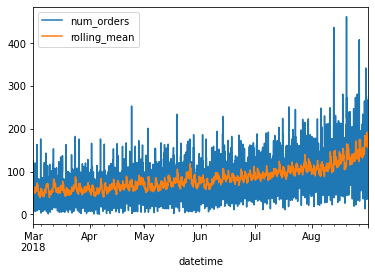

In [9]:
taxi_data.plot()

Text(0.5, 1.0, 'Seasonality')

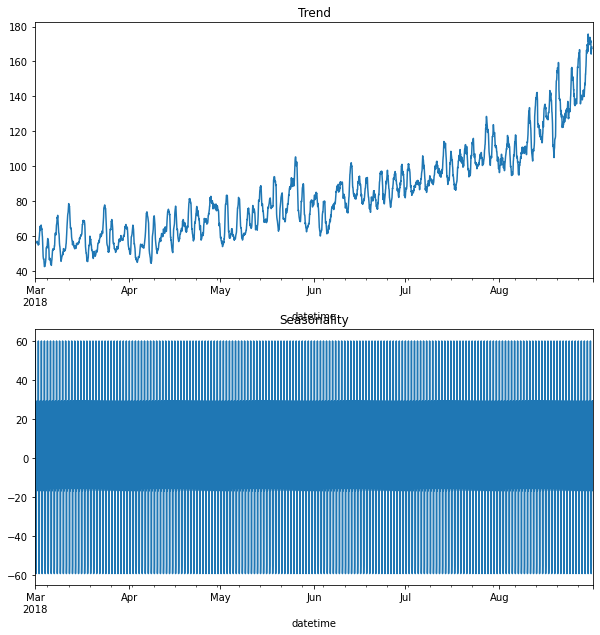

In [10]:
plt.figure(figsize=(10, 16))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Можем видеть, что начиная с Апреля кол-во заказов начинает медленно расти (люди больше путешествуют и немного чаще берут такси(?)), в  Июле-Августе этот рост усиливается. Скорее всего, это связанно со снижением температуры. Летом люди после выхода из аэропорта готовы немного прогуляться, но чем хуже погода, тем больше они берут такси.

Сезонность в таком масштабе смотреть бесполезно, но если его уменьшить, то можно найти что-то полезное:

Посмотрим на то, в какие часы чаще заказывают такси:

Text(0.5, 1.0, 'Seasonal')

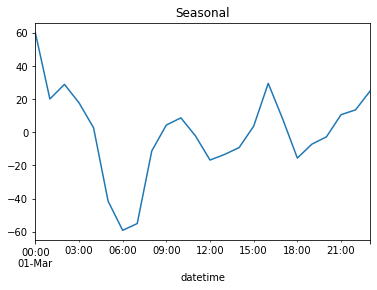

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-01'].plot()
plt.title('Seasonal')

Заметно, что чаще всего такси берут с `22 до 4`, кроме такси ничего и не работает. 

Меньше всего заказов `с 5 до 8 утра`, во-первых, в 5:30 начинает работу общественный транспорт и он может быть еще не нагружен, во-вторых, такая просадка может быть связанна и с расписанием полетов в аэропорту.

Взглянем на дни недели:

<AxesSubplot:title={'center':'Распределение заказов такси по дням недели'}, ylabel='num_orders'>

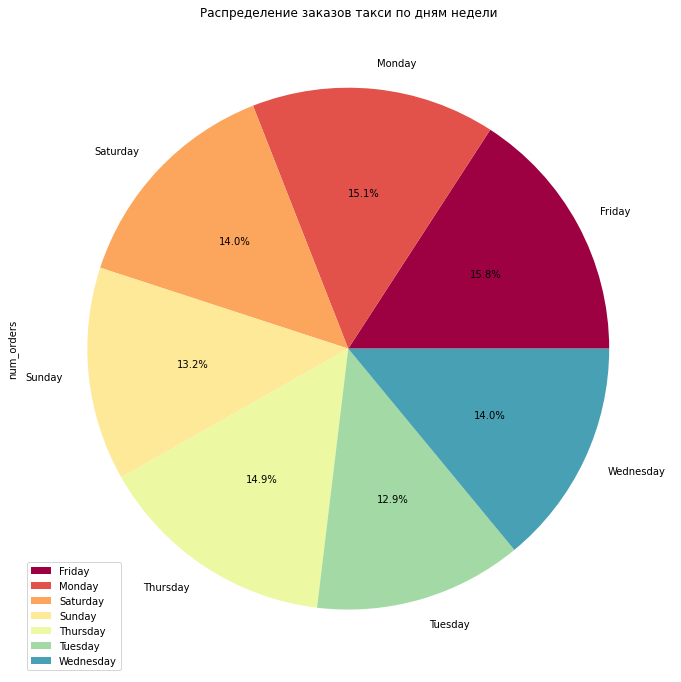

In [12]:
colors = [plt.cm.Spectral(i/float(7)) for i in range(7)]

taxi_data.pivot_table(index=taxi_data.index.strftime('%A'), values='num_orders', aggfunc=('sum')).plot(kind='pie',
                                                                                 figsize=(28,12),
                                                                                 y='num_orders', 
                                                                                 autopct='%1.1f%%',
                                                                                 colors=colors, 
                                                                    title='Распределение заказов такси по дням недели')

Похоже услугами такси пользуются, так или иначе, в любой день недели.  Чаще всего пользуются такси в пятницу, наверное, специально берут билеты на дату перед выходными. Реже всего - во вторник.

### Вывод:
Мы выяснили, что:
* Заметный рост заказов начинается в Июле
* Больше всего такси заказывают с 22 до 4
* Самый нагруженный день - пятница

## Обучение

Напишем функцию, чтобы создать признаки для обучения модели:

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Разделим выборку на тестовую, валидационную и обучающую:

In [14]:
data_train, data_test_and_valid = train_test_split(taxi_data, test_size=0.2, shuffle=False) 
data_valid, data_test = train_test_split(data_test_and_valid, test_size=0.5, shuffle=False) 

Параметры max_lag и rolling_mean_size придется случайным образом подбирать так, чтобы увеличивалась эффективность моделей:

In [15]:
make_features(taxi_data, 80, 300)

data_train, data_test_and_valid = train_test_split(taxi_data, test_size=0.2, shuffle=False) # выделим обучающую выборку.
data_valid, data_test = train_test_split(data_test_and_valid, test_size=0.5, shuffle=False) # оставим 10 % от общих данных 
                                                                                            # для теста и валидации
data_train = data_train.dropna()
    
features_train = data_train.drop('num_orders', axis=1)
target_train = data_train['num_orders']

features_valid = data_valid.drop('num_orders', axis=1)
target_valid = data_valid['num_orders']

features_test = data_test.drop('num_orders', axis=1)
target_test = data_test['num_orders']

Напишем функцию, которой будем передавать название модели и ее гиперпараметры для кросс-валидации в `GridSearchCV`, так же укажем ему нашу метрику в `scoring` - rmse:

In [16]:
models = []
time_to_fit = []
time_to_score = []
score = []
params = []

def CV_modeling(model, parameters_as_dict): # будем передавать нашей функции название модели и гиперпарамтры на перебор
    params_to_test = parameters_as_dict

    scoring =  make_scorer(mean_squared_error, greater_is_better=False, squared=False) # Наша основная метрика RMSE
    tscv = TimeSeriesSplit()
    
    model = model()
    grid_search = GridSearchCV(model, param_grid=params_to_test, n_jobs=6, verbose=1, scoring=scoring, cv=tscv)

    grid_search.fit(features_train, target_train)

    #Сохраним показатели лучшей модели

    models.append(model) #название модели
    params.append(grid_search.best_params_) # параметры модели
    time_to_fit.append(grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]) # время на обучние
    time_to_score.append(grid_search.cv_results_['mean_score_time'][grid_search.best_index_]) # время предсказания
    score.append(grid_search.cv_results_['mean_test_score'][grid_search.best_index_]) # выбранная метрика scoring

Теперь обучим разные модели:

**`LinearRegression`**

In [17]:
CV_modeling(LinearRegression, {})

Fitting 5 folds for each of 1 candidates, totalling 5 fits


**`RandomForestRegressor`**

In [18]:
CV_modeling(RandomForestRegressor, {'n_estimators': [50, 100, 150],
                                'max_depth': [5, 10, 15],
                                'random_state': [12345]
})

Fitting 5 folds for each of 9 candidates, totalling 45 fits


**`DecisionTreeRegressor`**

In [19]:
CV_modeling(DecisionTreeRegressor, {'max_depth': range(1, 20, 5),
                                    'random_state': [12345]
})

Fitting 5 folds for each of 4 candidates, totalling 20 fits


**`LGBMRegressor`**

In [20]:
%%time
CV_modeling(LGBMRegressor, {'n_estimators': range(50, 500, 100),
                            'max_depth': range(-1, 20, 5),
                            'num_leaves': [30,60],
                            'random_state': [12345],
                            'learning_rate': [0.1, 0.3, 0.5, 0.8, 1]
})

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Wall time: 2min 14s


**`CatBoostRegressor`**

In [21]:
%%time
CV_modeling(CatBoostRegressor, {'verbose':[999],
                               'random_state': [12345],
                               'depth': range(1, 12, 4),
                               })

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Learning rate set to 0.049281
0:	learn: 34.9274095	total: 155ms	remaining: 2m 34s
999:	learn: 10.5864742	total: 3.06s	remaining: 0us
Wall time: 1min 57s


### Взглянем на результаты:

In [22]:
final_data_results = pd.DataFrame({'time_to_fit': time_to_fit, 
                                   'time_to_score': time_to_score, 
                                   'rmse': score, 
                                   'parameters': params}, index=models).sort_values(by='rmse')

final_data_results

,time_to_fit,time_to_score,rmse,parameters
DecisionTreeRegressor(),0.044239,0.002002,-28.466683,"{'max_depth': 6, 'random_state': 12345}"
LinearRegression(),0.026424,0.002202,-23.492598,{}
RandomForestRegressor(),7.446755,0.020722,-22.830233,"{'max_depth': 15, 'n_estimators': 150, 'random..."
LGBMRegressor(),0.149861,0.005205,-22.587968,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti..."
<catboost.core.CatBoostRegressor object at 0x0000023512A7FCD0>,14.273081,0.019024,-22.114717,"{'depth': 5, 'random_state': 12345, 'verbose':..."


Catboost показал лучший результат, но он долго обучается, за ним идет LGBMRegressor и RandomForestRegressor с идентичными результатами.

In [23]:
print(final_data_results.iloc[[-1]]['parameters'].values) # лучший. Cat
print(final_data_results.iloc[[-2]]['parameters'].values) # второй по лучшести. LGBM

[{'depth': 5, 'random_state': 12345, 'verbose': 999}]
[{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150, 'num_leaves': 30, 'random_state': 12345}]


## Тестирование

Объеденим обучающую и валидационную выборку в обучающую перед тестом:

In [24]:
train_and_valid_features = features_train.append(features_valid)
train_and_valid_target = target_train.append(target_valid)

**`CatBoostRegressor`**

In [25]:
model = CatBoostRegressor(random_state=12345, depth=5, verbose=100)

model.fit(train_and_valid_features, train_and_valid_target)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
print(rmse)

Learning rate set to 0.050289
0:	learn: 37.8111325	total: 3.62ms	remaining: 3.62s
100:	learn: 21.8202409	total: 317ms	remaining: 2.82s
200:	learn: 19.7796235	total: 629ms	remaining: 2.5s
300:	learn: 18.1647364	total: 937ms	remaining: 2.17s
400:	learn: 16.7055845	total: 1.25s	remaining: 1.87s
500:	learn: 15.5602555	total: 1.56s	remaining: 1.55s
600:	learn: 14.5960079	total: 1.88s	remaining: 1.25s
700:	learn: 13.7684946	total: 2.19s	remaining: 935ms
800:	learn: 12.9842760	total: 2.5s	remaining: 622ms
900:	learn: 12.2586812	total: 2.81s	remaining: 309ms
999:	learn: 11.5680609	total: 3.16s	remaining: 0us
38.84540349939071


**`LGBMRegressor`**

In [26]:
model = LGBMRegressor(learning_rate=0.1, max_depth=4, n_estimators=150, num_leaves=30, random_state=12345)

model.fit(train_and_valid_features, train_and_valid_target)
predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, predictions, squared=False)
print(rmse)

38.677634057317135


На тестовой выборке лучше себя показал `LGBMRegressor`, он и работает быстрее и точнее, чем `CatBoostRegressor`

Чтобы проверить модель на адекватность используем `DummyRegressor`:

In [27]:
model = DummyRegressor()
model.fit(train_and_valid_features, train_and_valid_target)

fake_predictions = model.predict(features_test)
rmse = mean_squared_error(target_test, fake_predictions, squared=False)
print(rmse)

83.46819882591065


У нашей модели результаты куда лучше, значит она адекватна.

Построим график исходных данных и предсказанных:

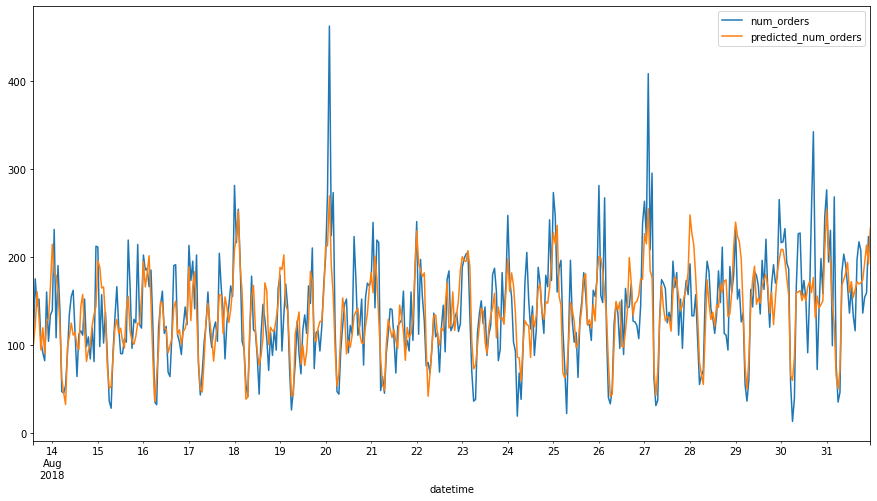

In [29]:
predictions = pd.Series(predictions.tolist())
predictions.index = target_test.index
predictions = pd.Series(predictions, name='predicted_num_orders')
data = pd.DataFrame(target_test).join([predictions]).plot(figsize=(15, 8))

## Вывод:
C параметрами `max_lag = 80` и `rolling_mean_size= 300` при формировании признаков для обучения:

Лучшая модель: `LGBMRegressor` с гипперапараметрами: 
* `learning_rate=0.1, max_depth=4, n_estimators=150, num_leaves=30, random_state=12345` 

* метрика `rmse = 38,6`

Судя по графику, наша модель может хорошо справляться в "целом", даже способна уловить некоторые аномальные значения. Но иногда все-таки промахивается. Стоит уделить отдельное внимание тем случаем, где модель ошиблась, возможно, это дни, когда произошло что-то такое, что ни одна машина не предскажет, и необходимо искать другие способы борьбы с нагрузкой в такие дни / часы.